In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from htc_projects.sepsis_icu.settings_sepsis_icu import settings_sepsis_icu
from htc_projects.sepsis_icu.utils import save_figure
from htc_projects.sepsis_icu.visualization_helpers import generate_df, generate_run_data

In [2]:
plt.rcParams["font.family"] = settings_sepsis_icu.font_family
plt.rcParams["font.sans-serif"] = settings_sepsis_icu.font
plt.rcParams["font.size"] = settings_sepsis_icu.font_size
plt.rcParams["xtick.labelsize"] = settings_sepsis_icu.font_size
plt.rcParams["ytick.labelsize"] = settings_sepsis_icu.font_size

In [3]:
def generate_figure(
    target: str = "sepsis",
    metric: str = "ROC",
    include_tpi: bool = True,
    include_unclear: bool = False,
    table_name: str = "test_table_new",
    subgroup_selection: str = "all",
):
    sites = ["palm", "finger"]
    fig, axes = plt.subplots(
        1, len(sites), figsize=(settings_sepsis_icu.page_width_inch, 3), sharey=True, constrained_layout=True
    )

    for j, site in enumerate(sites):
        target_runs = [
            f"image/{settings_sepsis_icu.model_timestamp}_{target}-inclusion_{site}_image_nested-*-4_seed-*-2",
            f"image/{settings_sepsis_icu.model_timestamp}_{target}-inclusion_{site}_image_tpi_nested-*-4_seed-*-2",
            f"image/{settings_sepsis_icu.model_timestamp}_{target}-inclusion_{site}_image_rgb_nested-*-4_seed-*-2",
        ]
        run_data = generate_run_data(target, target_runs, table_name, subgroup_selection=[subgroup_selection])
        _, df_agg, df = generate_df(run_data, target, subgroup=subgroup_selection)

        if include_unclear:
            run_data_unclear = generate_run_data(target, target_runs, table_name="test_table_unclear_sepsis_status")
            _, df_agg_unclear, df_unclear = generate_df(run_data_unclear, target)
            df_agg_unclear["model"] = df_agg_unclear["model"] + ", unclear"
            df_unclear["model"] = df_unclear["model"] + ", unclear"
            df_agg = pd.concat([df_agg, df_agg_unclear])
            df = pd.concat([df, df_unclear])

        display(df_agg)

        legend_entries = []
        legend_names = []

        models = df.model.unique()
        if not include_tpi:
            models = [model for model in models if "TPI" not in model]
        for m, model in enumerate(models):
            df_model = df.query("model == @model")
            metric_data_x = np.stack(df_model[f"{metric}_x"].values[0])
            metric_data_y = np.stack(df_model[f"{metric}_y"].values[0])

            x_50 = np.percentile(metric_data_x, q=50, axis=0)
            y_50 = np.percentile(metric_data_y, q=50, axis=0)
            y_025 = np.percentile(metric_data_y, q=2.5, axis=0)
            y_975 = np.percentile(metric_data_y, q=97.5, axis=0)

            minimum_ppv_median = np.median(np.stack(df_model["minimum_ppv"].values))
            minimum_ppv_std = np.std(np.stack(df_model["minimum_ppv"].values))

            axes[j].grid(True, linestyle="dotted")
            p1 = axes[j].plot(x_50, y_50, color=settings_sepsis_icu.model_colors[model])

            if metric == "PRC" and m == 0:
                p3 = axes[j].plot(
                    x_50,
                    np.repeat(minimum_ppv_median, len(x_50)),
                    color="gray",
                    linestyle="--",
                )
                p4 = axes[j].fill_between(
                    x_50,
                    minimum_ppv_median - minimum_ppv_std,
                    minimum_ppv_median + minimum_ppv_std,
                    alpha=0.2,
                    color="gray",
                )
                legend_entries.append((p3[0], p4))
                legend_names.append(f"baseline (AUPRC={minimum_ppv_median:.2f}±{minimum_ppv_std:.2f})")

            p2 = axes[j].fill_between(
                x_50,
                y_025,
                y_975,
                alpha=0.2,
                color=settings_sepsis_icu.model_colors[model],
            )

            legend_entries.append((p1[0], p2))
            agg_median = df_agg[df_agg["model"] == model][f"median_AU{metric}"].values[0]
            agg_std = df_agg[df_agg["model"] == model][f"std_AU{metric}"].values[0]
            legend_names.append(f"{model} (AU{metric}={agg_median:.2f}±{agg_std:.2f})")

        if metric == "PRC":
            loc = "upper right"
        else:
            loc = "upper left"

        legend = axes[j].legend(
            legend_entries,
            legend_names,
            loc=loc,
            # bbox_to_anchor=bbox_anchor,
            ncol=1,
            fontsize=settings_sepsis_icu.font_size_small,
        )

        axes[j].set_title(site)
        if metric == "ROC":
            axes[j].set_xlabel("false positive rate", fontsize=settings_sepsis_icu.font_size)
            if j == 0:
                axes[j].set_ylabel("true positive rate", fontsize=settings_sepsis_icu.font_size)

        elif metric == "PRC":
            axes[j].set_xlabel("true positive rate", fontsize=settings_sepsis_icu.font_size)
            if j == 0:
                axes[j].set_ylabel("positive predictive value", fontsize=settings_sepsis_icu.font_size)

        savepath = settings_sepsis_icu.results_dir / "paper_figures" / f"HSI_vs_RGB_{metric}_{target}.pdf"
        savepath.parent.mkdir(parents=True, exist_ok=True)
        save_figure(savepath, fig, dpi=300)

[WARNING][py.warnings] /home/silvia/htc/src/htc_projects/sepsis_icu/visualization_helpers.py:155:        warnings.py:110
FutureWarning: The provided callable <function median at 0x78c5f82665c0> is currently using                             
SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To                    
keep current behavior pass the string "median" instead.                                                                 
  df_agg = df_exploded.groupby(["model", "metadata", "site"], as_index=False).agg(                                      
                                                                                                                        

[WARNING][py.warnings] /home/silvia/htc/src/htc_projects/sepsis_icu/visualization_helpers.py:155:        warnings.py:110
FutureWarning: The provided callable <function std at 0x78c5f8329760> is currently using                                
SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep                  
current behavior pass the string "std" instead.                                                                         
  df_agg = df_exploded.groupby(["model", "metadata", "site"], as_index=False).agg(                                      
                                                                                                                        

,model,metadata,site,median_AUROC,std_AUROC,percentile_025_AUROC,percentile_975_AUROC,median_AUPRC,std_AUPRC,percentile_025_AUPRC,percentile_975_AUPRC,median_brier_binary,std_brier_binary,percentile_025_brier_binary,percentile_975_brier_binary
0,HSI,HSI alone,palm,0.802,0.021818,0.758951,0.842993,0.583152,0.045941,0.500032,0.675963,0.196912,0.005132,0.186978,0.206588
1,RGB,RGB alone,palm,0.670264,0.028772,0.617664,0.728306,0.440276,0.042128,0.363603,0.528180,0.222096,0.004730,0.213321,0.230932
2,TPI,TPI alone,palm,0.782616,0.022591,0.740921,0.828689,0.557441,0.046136,0.466565,0.649634,0.197696,0.005537,0.186827,0.208328


,model,metadata,site,median_AUROC,std_AUROC,percentile_025_AUROC,percentile_975_AUROC,median_AUPRC,std_AUPRC,percentile_025_AUPRC,percentile_975_AUPRC,median_brier_binary,std_brier_binary,percentile_025_brier_binary,percentile_975_brier_binary
0,HSI,HSI alone,finger,0.722173,0.026812,0.668900,0.775470,0.526292,0.046028,0.437318,0.615406,0.223228,0.003856,0.215598,0.230399
1,RGB,RGB alone,finger,0.587821,0.030210,0.527206,0.643968,0.379954,0.037731,0.312427,0.458088,0.24278,0.002655,0.237595,0.247839
2,TPI,TPI alone,finger,0.731959,0.025655,0.680125,0.779681,0.519298,0.045890,0.429250,0.608455,0.217138,0.004568,0.208033,0.226216


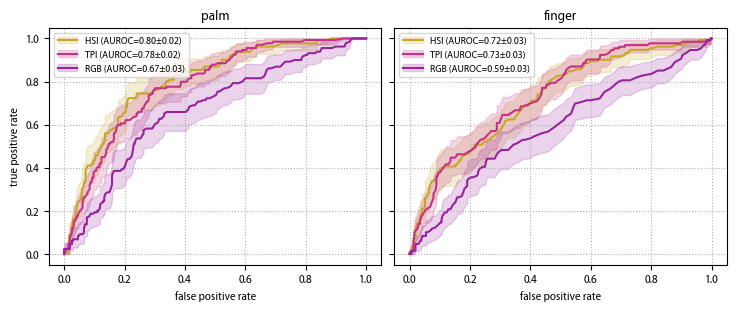

In [4]:
generate_figure("sepsis")

,model,metadata,site,median_AUROC,std_AUROC,percentile_025_AUROC,percentile_975_AUROC,median_AUPRC,std_AUPRC,percentile_025_AUPRC,percentile_975_AUPRC,median_brier_binary,std_brier_binary,percentile_025_brier_binary,percentile_975_brier_binary
0,HSI,HSI alone,palm,0.72148,0.036451,0.651738,0.789108,0.338303,0.055016,0.242460,0.459289,0.201586,0.004178,0.193222,0.210024
1,RGB,RGB alone,palm,0.66187,0.038351,0.586940,0.738657,0.249435,0.041105,0.178592,0.339485,0.189003,0.004465,0.180107,0.197347
2,TPI,TPI alone,palm,0.741589,0.031917,0.676884,0.803489,0.372546,0.057972,0.261029,0.491080,0.187986,0.004662,0.178652,0.196834


,model,metadata,site,median_AUROC,std_AUROC,percentile_025_AUROC,percentile_975_AUROC,median_AUPRC,std_AUPRC,percentile_025_AUPRC,percentile_975_AUPRC,median_brier_binary,std_brier_binary,percentile_025_brier_binary,percentile_975_brier_binary
0,HSI,HSI alone,finger,0.66465,0.037733,0.587418,0.734326,0.257357,0.043765,0.178926,0.357983,0.223248,0.003541,0.216134,0.229823
1,RGB,RGB alone,finger,0.608069,0.036320,0.536559,0.681673,0.248841,0.044474,0.168112,0.343296,0.221133,0.002806,0.215419,0.226593
2,TPI,TPI alone,finger,0.637931,0.039597,0.555630,0.714621,0.253832,0.046391,0.175502,0.360869,0.216964,0.003975,0.209070,0.224445


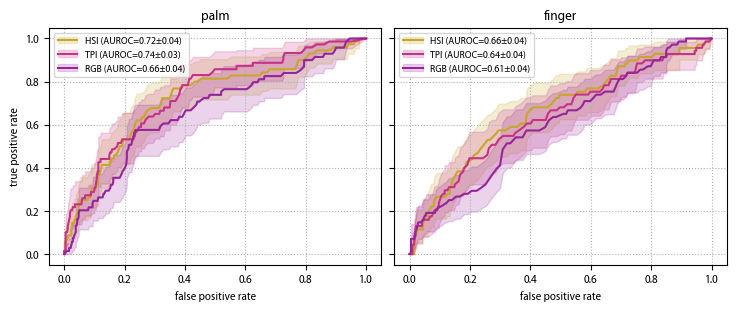

In [5]:
generate_figure("survival")

,model,metadata,site,median_AUROC,std_AUROC,percentile_025_AUROC,percentile_975_AUROC,median_AUPRC,std_AUPRC,percentile_025_AUPRC,percentile_975_AUPRC,median_brier_binary,std_brier_binary,percentile_025_brier_binary,percentile_975_brier_binary
0,HSI,HSI alone,palm,0.658248,0.046779,0.569770,0.750960,0.499786,0.064346,0.383141,0.632655,0.240093,0.007564,0.225903,0.255079
1,RGB,RGB alone,palm,0.531354,0.050099,0.440972,0.631974,0.452061,0.062460,0.330225,0.576947,0.250011,0.007857,0.234169,0.265377
2,TPI,TPI alone,palm,0.693935,0.045666,0.598664,0.777367,0.56968,0.067731,0.439769,0.707040,0.231745,0.007643,0.217291,0.246954


,model,metadata,site,median_AUROC,std_AUROC,percentile_025_AUROC,percentile_975_AUROC,median_AUPRC,std_AUPRC,percentile_025_AUPRC,percentile_975_AUPRC,median_brier_binary,std_brier_binary,percentile_025_brier_binary,percentile_975_brier_binary
0,HSI,HSI alone,finger,0.62002,0.049181,0.512231,0.710135,0.538381,0.066455,0.398776,0.651930,0.241408,0.004793,0.231927,0.251042
1,RGB,RGB alone,finger,0.627087,0.050068,0.532138,0.728205,0.481772,0.067130,0.362171,0.632560,0.237817,0.006572,0.224368,0.250945
2,TPI,TPI alone,finger,0.601594,0.050804,0.503071,0.699899,0.55369,0.063599,0.417455,0.663432,0.238926,0.005562,0.227595,0.249297


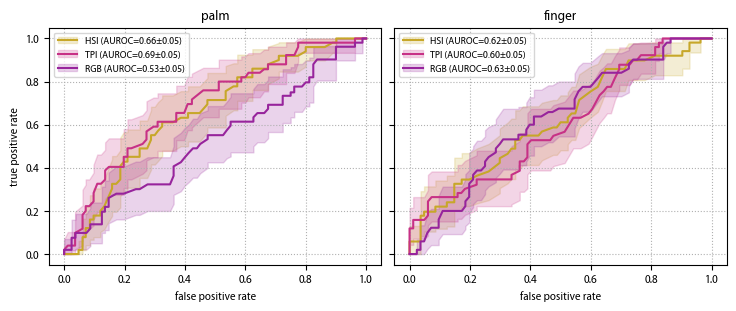

In [6]:
generate_figure("shock", subgroup_selection="sepsis")